In [1]:
import numpy as np
import pandas as pd
import matplotlib
import sklearn as skl
from scipy.optimize import minimize
import seaborn as sns
from matplotlib import pyplot as plt
import plotly as ply
import tqdm
import gc
import sys
import os
import scipy as sp
import json
import copy

# First, let's setup a small symmetric potential (you can modify the shape, but keep the energy barrier ~1kT, so your test simulation will converge faster) 

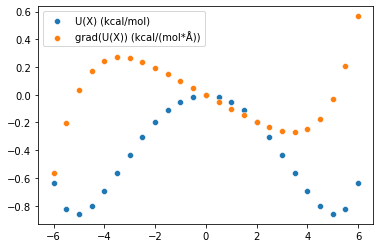

In [2]:
# a*x^6-b*x^2 has minima in x =+-1 and a barrier at x=0
# The ratio a/b can must be tuned depending on the kT used in the brownian dynamics, so that the barrier can be crossed repeatedly.

def potFun(x):
    return(0.05*((1/2000)*(x)**6-(x)**2))
def potGradFun(x):
    return(0.05*((6.0/2000)*(x)**5-2.0*(x)))

xgrid=np.linspace(-6,6,25)
sns.scatterplot(
    x=xgrid,
    y=potFun(xgrid),
    label='U(X) (kcal/mol)'
)


sns.scatterplot(
    x=xgrid,
    y=potGradFun(xgrid),
    label='grad(U(X)) (kcal/(mol*Å))'
)


plt.show()

# Question 1: Knowing the U(x), can you compute a PMF using this equation from our lecture? We sometime call this equation Boltzmann inversion because k is Boltzmann constant.
# $\Delta G(x)= -kTlog \frac{P(x)}{Z} = -kTlog \frac{\int exp(-U(x)/kT) dx }{Z}$  eq(1)

In [3]:
# setup bins/windows
binEdges=np.linspace(-6,6,25)
binCenters=(binEdges[:-1]+binEdges[1:])/2.
print("binCenters",binCenters, "total bins", len(binCenters))
xgrid=binCenters

# setup kT
kb=0.001985875 # Boltzmann constant
Tsim=310.15
kbT=kb*Tsim
print("kT",kbT, )


binCenters [-5.75 -5.25 -4.75 -4.25 -3.75 -3.25 -2.75 -2.25 -1.75 -1.25 -0.75 -0.25
  0.25  0.75  1.25  1.75  2.25  2.75  3.25  3.75  4.25  4.75  5.25  5.75] total bins 24
kT 0.6159191312499999


# Question 2: What are the meaning of the data points on your plot? Overlay with the U(x) curve, did you recover the same potential energy profile? Why? 

Partition function Z is 27.483821433938047


<AxesSubplot:>

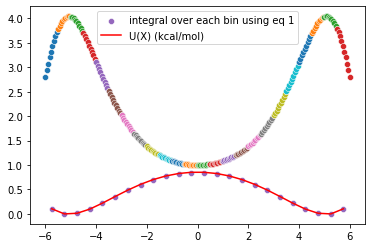

In [4]:
# Integral over the whole potential gives Z as the partition function (we normall don't compute it because we don't know the U(x))
Allxx=np.linspace(-6,6,300)
Z=np.trapz(y=np.exp(-(potFun(Allxx))/kbT), x=Allxx)
print("Partition function Z is",Z)


# Now integral over each bin
f=[]
temp=[]
tot=[]

for a in np.linspace(-6,5.5,24):
    xx=np.linspace(a,a+0.5,10)
    prob=np.exp(-(potFun(xx))/kbT)
    sns.scatterplot(x=xx, y=prob)
    integral=(np.trapz(y=prob, x=xx))/Z
    f=-kbT*np.log(integral)
    temp.append(copy.deepcopy(f))

sns.scatterplot(x=binCenters, y=temp-np.min(temp),label="integral over each bin using eq 1")  
sns.lineplot(x=xgrid,
    y=potFun(xgrid)-np.min(potFun(xgrid)),
    label='U(X) (kcal/mol)', color='r')

# Now let's run an unbiased simulation. 
# For the simplicity, we will use Brownian dynamics (overdamped Langevin dynamics). Check the difference in their equations.
# Here we pretend we don't know the underlying U(x), we want to compute PMF directly from simulated data
# Labele x-axis and y-axis for each plot based on your understanding

In [5]:
# Assuming we are simulating a water molecule moving along x-axis in air in presence of U(x)
# diffusion constant of a water molecle in air is: .282 cm**2/s = 2.82 Å**2/fs (at 25 ºC)
%cd /data/lyna/teaching
import analysis_functions

diffCoef=2.82*310.15/298.15 #Approximate scaling to body temperature 

bd_Sim=analysis_functions.Simple_1D_BD_Sim(potGradFun)
bd_Sim.set_parameters(dict(
    diffusionConstant=diffCoef,
    vmax=15.0, #maximum allowed velocity before terminating simulation due to instability
    trajectorySnapshotRate=10, # frequency of saving trajectory
    verbose=True,
    timestep=0.1 # fs
))

print(bd_Sim.parameter_dict)



/data/lyna/teaching
{'diffusionConstant': 2.933499916149589, 'temperature': 310.15, 'vmax': 15.0, 'trajectorySnapshotRate': 10, 'periodicBoundaryLength': None, 'timestep': 0.1, 'verbose': True}


20000
Done


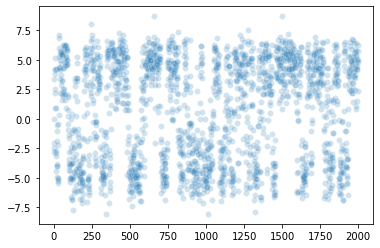

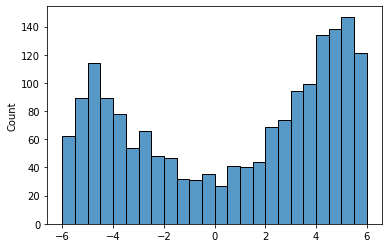

In [6]:
nsteps=20000 # how many ns did you simulate?
trajData=bd_Sim.run_sim(
    nsteps=nsteps,
    giveVelocities=True)
print("Done")

# plot raw simulated data
sns.scatterplot(x=np.arange(0, len(trajData['trajectory'])), y=trajData['trajectory'], alpha=0.2)
plt.show()

# convert raw data to histogram. Is your histogram symmetric? If not, what do you do?
sns.histplot(trajData['trajectory'],bins=binEdges)
plt.show()

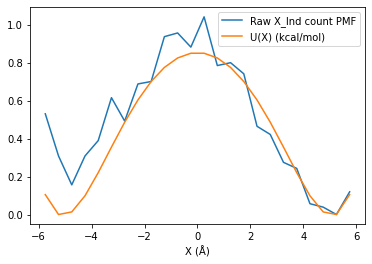

In [7]:
# Now convert histogram to PMF using Boltzmann inversion

sim_pmf_hist=np.histogram(
    a=trajData['trajectory'],
    bins=binEdges
)

sim_pmf_vec=sim_pmf_hist[0]
sim_pmf_vec=sim_pmf_vec/np.sum(sim_pmf_vec) # normalize histogram
sim_pmf_vec=-kbT*np.log(sim_pmf_vec/np.max(sim_pmf_vec))

sns.lineplot(
    x=xgrid,
    y=sim_pmf_vec,
    label='Raw X_Ind count PMF'
)

sns.lineplot(
    x=xgrid,
    y=potFun(xgrid)-np.min(potFun(xgrid)),
    label='U(X) (kcal/mol)'
)

plt.xlabel('X (Å)')
plt.show()

In [8]:
# save simulated data
rawZ=[]
ts=0.1 
trajectorySnapshotRate=10  # framesize 1fs

rawZ=pd.DataFrame(trajData['trajectory'],columns=['Z'])
rawZ['time']=np.arange(0,nsteps/trajectorySnapshotRate)
print(rawZ.head())
rawZ.to_csv('1D-BDtraj.csv',header=True, index=False)

          Z  time
0  0.000000   0.0
1 -2.071524   1.0
2 -2.779533   2.0
3 -2.502682   3.0
4  3.404543   4.0


# Comput position and velocity correlation time
# How long it takes for each datapoint to become independent from previous data?

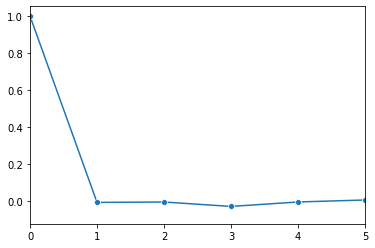

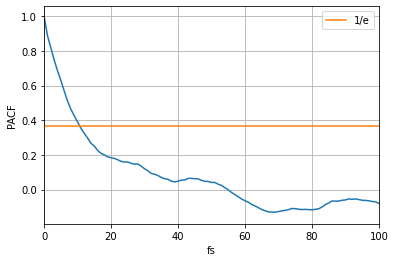

positional autocorr time in fs 11.523407972913267


In [9]:
import pymbar
from pymbar import timeseries
import pytraj as pt
import math

sns.lineplot(x=np.arange(len(trajData['velocities'])),y=pt.acorr(trajData['velocities']),marker='o')
plt.xlim(0,5)
plt.show()
sns.lineplot(x=np.arange(len(trajData['trajectory'])),y=pt.acorr(trajData['trajectory']))
sns.lineplot(x=np.arange(len(trajData['trajectory'])),y=1/math.e, label="1/e")
plt.xlim(0,100)
plt.xlabel("fs")
plt.ylabel("PACF")
plt.grid()
plt.show()

corrTime=timeseries.statisticalInefficiency(trajData['trajectory'])
print("positional autocorr time in fs", (corrTime-1)/2)


# Use your computed positional correlation time, what is the standard error of mean of your sample?

# Lets calculate the averages and std as a function of time. How long does it take for your average value and standard deviation value to converge?

/home/lyna/.local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/lyna/.local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

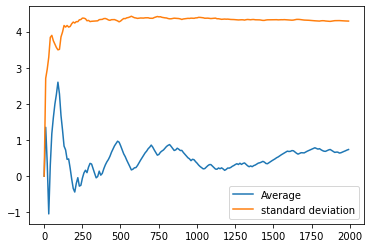

In [10]:
data=rawZ.Z
ave_time=[]
std_time=[]

frame=[]
for i in range(1,len(data),10):
  frame.append(i)
  ave_time.append(copy.deepcopy(np.mean(data[0:i])))
  std_time.append(copy.deepcopy(np.sqrt(np.var(data[0:i]))))
  

sns.lineplot(frame,ave_time,label='Average')
sns.lineplot(frame,std_time, label="standard deviation")


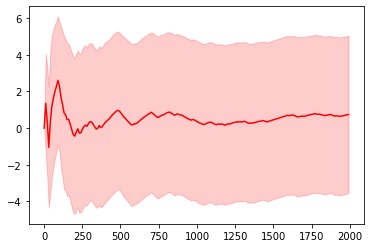

In [11]:
# a better representation of avg and std

ave_upper=np.asarray(ave_time)+np.asarray(std_time)
ave_lower=np.asarray(ave_time)-np.asarray(std_time)

plt.plot(frame,ave_time,label=' Average',c='r')
plt.fill_between(frame, ave_upper, ave_lower, color='red', alpha=0.2)
plt.show()

In [12]:
#Now Lets Split Our Trajectory Up Into Chunks or "Blocks" of Equal sizes
def chunkIt(numFrames, numBlocks):
    avg = numFrames / float(numBlocks)
    out = []
    last = 0.0
    while last < numFrames-1:
        out.append([int(last),int(last+avg)])
        last += avg
    return out

print("split 2000 frames into 10 blocks", chunkIt(2000, 10))
Ind=chunkIt(2000,10)
block_size=(Ind[0][1]-Ind[0][0])
print("Block Size:", block_size,"Blocks:",10)

split 2000 frames into 10 blocks [[0, 200], [200, 400], [400, 600], [600, 800], [800, 1000], [1000, 1200], [1200, 1400], [1400, 1600], [1600, 1800], [1800, 2000]]
Block Size: 200 Blocks: 10


# Based on this analysis, what block size will you choose for block averaging?

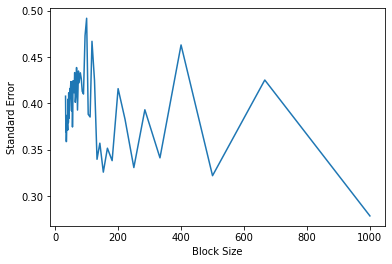

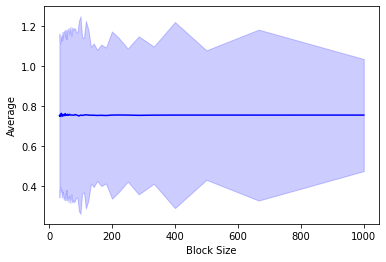

<Figure size 432x288 with 0 Axes>

In [13]:

b_var=[]
b_sd=[]
b_size=[]
b_ave=[]  
b_stderr=[]
frames=len(data)
n_blocks=60 # maximum number of blocks
for j in range(2,n_blocks,1):
 indices= chunkIt(frames,j)
 ave=[]
 for i in range(0,len(indices)):
  ave.append((np.average(data[indices[i][0]:indices[i][1]])))
 b_ave.append((np.average(ave)))
 b_var.append((np.var(ave)))
 b_size.append((indices[0][1]-indices[0][0]))
 b_stderr.append((np.sqrt(np.var(ave)/j)))

plt.plot(b_size,b_stderr)
plt.xlabel("Block Size")
plt.ylabel("Standard Error")
plt.show()
plt.clf()

upper=np.asarray(b_ave)+np.asarray(b_stderr)
lower=np.asarray(b_ave)-np.asarray(b_stderr)
plt.plot(b_size,b_ave,color='b')
plt.fill_between(b_size, upper, lower, color='b', alpha=0.2)

plt.xlabel("Block Size")
plt.ylabel("Average")

plt.show()
plt.clf()




# Now let's use your block size to compute the error bar for your PMF

Block Size: 200 Blocks: 10


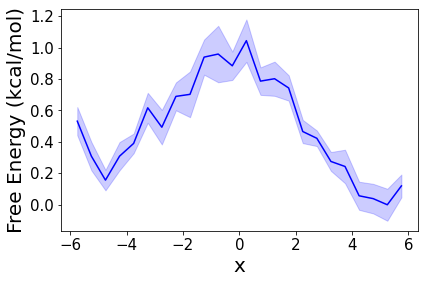

In [14]:
# Now let's add error bars from blockerror method

def free_energy_1D_blockerror(a,T,x0,xmax,bins,blocks):
  histo,xedges=np.histogram(a,bins=bins,range=[x0,xmax],density=True,weights=None)
  max=np.max(histo)  
  free_energy=-(0.001987*T)*np.log(histo+.000001)
  free_energy=free_energy-np.min(free_energy)
  xcenters= xedges[:-1] + np.diff(xedges)/2
  
  Ind=chunkIt(len(a),blocks)
  block_size=(Ind[0][1]-Ind[0][0])
  print("Block Size:", block_size,"Blocks:",blocks)
  
  hist_blocks=[]
  for i in range(0,len(Ind)):
   block_data=a[Ind[i][0]:Ind[i][1]]
   hist,binedges=np.histogram(block_data,bins=bins,range=[x0,xmax],density=True,weights=None)
   hist_blocks.append(hist)
  hist_blocks=np.array(hist_blocks)
  average=np.average(hist_blocks,axis=0)
  variance=np.var(hist_blocks,axis=0)
  N=len(hist_blocks)
  error = np.sqrt( variance / N ) 
  ferr = -(0.001987*T)*(error / average)
  return free_energy,xcenters,ferr


dG,bin_centers,ferr=free_energy_1D_blockerror(trajData['trajectory'], 310.15, -6.0, 6.0, binEdges,10)
sns.lineplot(x=bin_centers,y=dG,color='blue')
plt.fill_between(bin_centers, dG-ferr, dG+ferr, color='blue', alpha=0.2)

plt.xlabel('x', size=20)
plt.ylabel('Free Energy (kcal/mol)', size=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(size='15')
plt.yticks(size='15')
plt.tight_layout()
outdir="/data/lyna/teaching/"
np.savetxt(outdir+'BD.dG.err.dat',np.column_stack((bin_centers, dG,ferr)))
plt.tight_layout()
plt.savefig('%s/BD.dG.pdf'%outdir)
plt.show()

# Now it's your turn to run BD simulation using different timestep and diffusion constant, and plot your own well-converged PMF with nice error bars.

# Another way to run block error is to use pyblock
#https://github.com/jsspencer/pyblock/blob/master/docs/tutorial.rst

In [15]:
!pip install --user pyblock

You are using pip version 19.0.3, however version 23.1.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


BlockTuple(block=0, ndata=2000, mean=array(0.75514657), cov=array(18.41983687), std_err=array(0.09596832), std_err_err=array(0.00151777))
BlockTuple(block=1, ndata=1000, mean=array(0.75514657), cov=array(17.38945431), std_err=array(0.13186908), std_err_err=array(0.00295016))
BlockTuple(block=2, ndata=500, mean=array(0.75514657), cov=array(16.33798744), std_err=array(0.18076497), std_err_err=array(0.00572202))
BlockTuple(block=3, ndata=250, mean=array(0.75514657), cov=array(14.50092626), std_err=array(0.24083958), std_err_err=array(0.01079228))
BlockTuple(block=4, ndata=125, mean=array(0.75514657), cov=array(12.05596139), std_err=array(0.31056029), std_err_err=array(0.0197206))
BlockTuple(block=5, ndata=62, mean=array(0.72309816), cov=array(8.94129972), std_err=array(0.37975586), std_err_err=array(0.03438148))
BlockTuple(block=6, ndata=31, mean=array(0.72309816), cov=array(5.79722597), std_err=array(0.43244339), std_err_err=array(0.0558282))
BlockTuple(block=7, ndata=15, mean=array(0.66

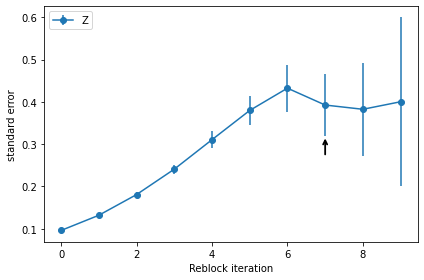

Z                                                  
             mean standard error standard error error optimal block
reblock                                                            
0        0.755147       0.095968             0.001518              
1        0.755147       0.131869             0.002950              
2        0.755147       0.180765             0.005722              
3        0.755147       0.240840             0.010792              
4        0.755147       0.310560             0.019721              
5        0.723098       0.379756             0.034381              
6        0.723098       0.432443             0.055828              
7        0.666760       0.392554             0.074186      <---    
8        0.748512       0.382528             0.110426              
9        0.547493       0.400346             0.200173

In [16]:
import pyblock
reblock_data = pyblock.blocking.reblock(np.asarray(data))
for reblock_iter in reblock_data:
    print(reblock_iter)
    
opt = pyblock.blocking.find_optimal_block(len(data), reblock_data)
print(opt)
print(reblock_data[opt[0]])

data_pd=pd.Series(data)
(data_length, reblock_data, covariance)=pyblock.pd_utils.reblock(data_pd)
pyblock.plot.plot_reblocking(reblock_data);
reblock_data